# Imports Packages

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np

from pandas_plink import read_plink
from scipy.special import softmax
from numpy.random import default_rng 

In [2]:
seed = 3
rng = default_rng(seed=seed)
path = '../data/' # relative path to data directory

# Import Data

In [3]:
bim, fam, bed = read_plink(path + 'CEDAR/CEDAR')
bed # [730K SNPs x 322 ppl] = [num_total_SNPs x num_ppl]

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]


dask.array<transpose, shape=(730525, 322), dtype=float32, chunksize=(1024, 322), chunktype=numpy.ndarray>

# Set Defaults

In [32]:
# default values
num_cs = 500 # num causal SNPs
num_annotations = 5
num_loci = 100

max_num_SNPs = 2000 # max num of SNPs any loci might have, set manually
num_ppl = bed.shape[1]

In [33]:
# generate weight vector w [num_annotations x 1]
w = np.ones(num_annotations) * 5

# sample which loci the causal SNPs will be located in [num_causal_snp x 1]
cs_loci = rng.integers(low=0, high=num_loci, size=(num_cs))

# simulated phenotype y [num_ppl x 1]
y = np.zeros(num_ppl)

In [34]:
# dict of causal SNPs C: C[locus] --> causal SNPs within that locus
# C[4] = [834, 232] means causal SNPs are located in locus 2 at SNP 834 and 232

C = defaultdict(list)

# Generate Synthetic Data

In [35]:
def genotype_data(locus_num):
    """ Extract genotype data X from dask array
    
    If SNP has any Nan values, remove the SNP completely. 

    Args:
        locus_num (int): num of locus from which to extract genotype data

    Returns:
        X ([num_ppl x num_SNPs]): genotype data for specified locus
    """
    
    # extract genotype matrix X [num_ppl x num_SNPs]
    X = bed.blocks[2*locus_num : 2*locus_num +2].compute().T 
    return X[:, ~np.any(np.isnan(X),axis=0)] # remove SNPs w/ Nan values

def update_cs_indicies(C, locus_num, causal_idx):
    """ Store SNP index and locus num of causal SNP in matrix C 

    Args:
        C [num_cs x 2]: store indicies of causal SNP by locus num and SNP index
        locus_num (int): num locus in which causal SNP appears
        causal_idx [num_locus_cs x 1]: arr w/ indicies of causal SNP in given locus
        offset (int): count how many causal SNPs already seen to correctly index into C
    """
    
    # iterate over number of causal SNPs in this locus
    for i, snp_num in enumerate(causal_idx):
        C[locus_num].append(snp_num)

In [36]:
# iterate over loci
for l in range(num_loci):
    X = genotype_data(l) # [num_ppl x num_SNPs]
    num_ppl, num_snp = X.shape # shape of genotype matrix X
    num_locus_cs = np.count_nonzero(l == cs_loci) # num of causal SNPs in locus l [1 x 1]

    # sample functional annotations [num_snp x num_annotations]
    A = rng.binomial(n=1, p=0.1, size=(num_snp, num_annotations)) # binomial with n=1 is bernoulli

    # generate prior causality vector pi [num_snp x 1]
    pi = softmax(A @ w)

    # sample casual SNPs [num_locus_cs x 1] according to pi
    causal_one_hot = rng.multinomial(n=1, pvals=pi, size=num_locus_cs) # multinomial with n=1 is categorical
    causal_idx = causal_one_hot.argmax(axis=-1) # convert from one-hot encoding to arr of idicies with causal SNPs

    update_cs_indicies(C, l, causal_idx)

    # sample effect size [num_snp x 1] which is non-zero for causal SNPs only
    beta = np.zeros(num_snp)
    if num_locus_cs != 0:
        beta[causal_idx] = rng.multivariate_normal(mean=np.zeros(num_locus_cs), 
                                                cov=np.eye(num_locus_cs))
        
    # sample error [num_ppl]
    eps = rng.multivariate_normal(mean=np.zeros(num_ppl), 
                             cov=np.eye(num_ppl) * 0.1)

    # add the effect of causal SNPs in locus l (as captured by beta)
    # and error term eps to simulated phenotype y [num_ppl x 1]
    y = X @ beta + eps

    # save genotype matrix X, phenotype vector y, and annotation matrix A
    fname = path + 'loci_' + str(l)
    np.savez_compressed(fname, genotype=X, phenotype=y, annotation=A)

# save annotation weight vector w and causal SNPs matrix C
fname = path + 'global_params'
np.savez_compressed(fname, weight=w, cs_idx=C)
        

In [31]:
np.sort(-pi) * -1

array([1.52759897e-01, 1.52759897e-01, 1.52759897e-01, 1.52759897e-01,
       1.52759897e-01, 1.52759897e-01, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
       1.02928809e-03, 1.02928809e-03, 1.02928809e-03, 1.02928809e-03,
      

(array([927.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.]),
 array([4.67296069e-08, 1.52760317e-02, 3.05520167e-02, 4.58280018e-02,
        6.11039868e-02, 7.63799718e-02, 9.16559568e-02, 1.06931942e-01,
        1.22207927e-01, 1.37483912e-01, 1.52759897e-01]),
 <BarContainer object of 10 artists>)

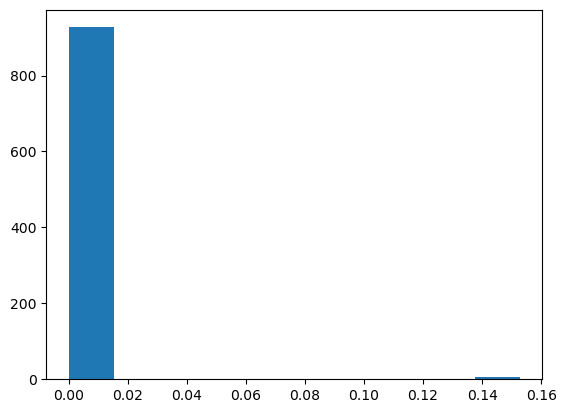

In [23]:
import matplotlib.pyplot as plt
plt.hist(pi)